In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 1. set up, 데이터 준비하기

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


**imbalanced한 데이터 이므로 처리가 필요하다**

In [8]:
# mini-batch로 작업하기 위해 tf.data 인스턴스 생성
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
#라벨을 만들어주는 함수 생성

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
#이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈 축소
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img


def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
# train, validation set 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
# 전처리 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 2. 데이터 시각화

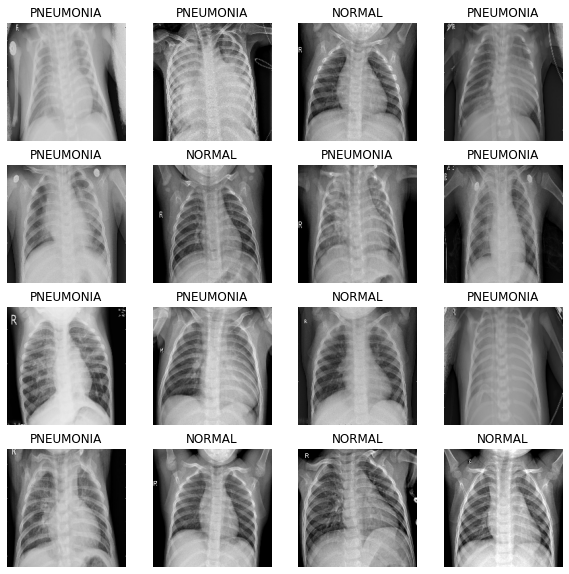

In [15]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 3. 모델 생성

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

## 4. 모델 학습

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 61s 189ms/step - loss: 0.3783 - accuracy: 0.8324 - precision: 0.9578 - recall: 0.8104 - val_loss: 0.7378 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2276 - accuracy: 0.9076 - precision: 0.9762 - recall: 0.8976 - val_loss: 1.1800 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1984 - accuracy: 0.9255 - precision: 0.9742 - recall: 0.9243 - val_loss: 0.5560 - val_accuracy: 0.7587 - val_precision: 0.7530 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1918 - accuracy: 0.9272 - precision: 0.9788 - recall: 0.9221 - val_loss: 0.4871 - val_accuracy: 0.8269 - val_precision: 1.0000 - val_recall: 0.7641
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1658 - accura

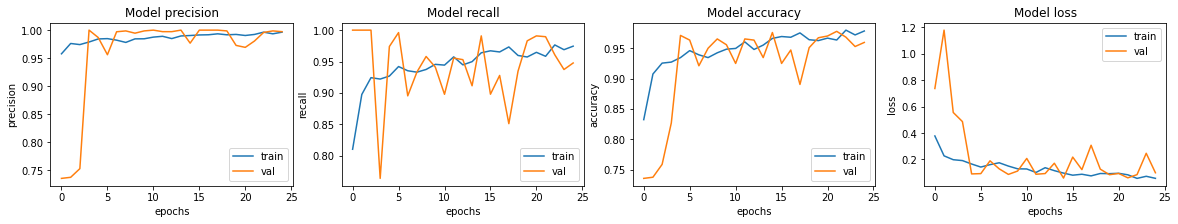

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 0.5373 - accuracy: 0.9022 - precision: 0.8799 - recall: 0.9769
Loss: 0.5372956395149231,
Accuracy: 0.9022436141967773,
Precision: 0.8799076080322266,
Recall: 0.9769230484962463


## 5. Data agumentation

In [25]:
def augment1(image,label):
    
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label
    
def augment2(image,label):
    
    image = tf.image.random_flip_up_down(image)  # 랜덤하게 상하를 반전
    return image,label
    
def prepare_for_training(ds, shuffle_buffer_size=1000):
        
    ds = ds.map(augment1,num_parallel_calls=2)
    ds = ds.map(augment2,num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat() 
    ds = ds.batch(BATCH_SIZE) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds




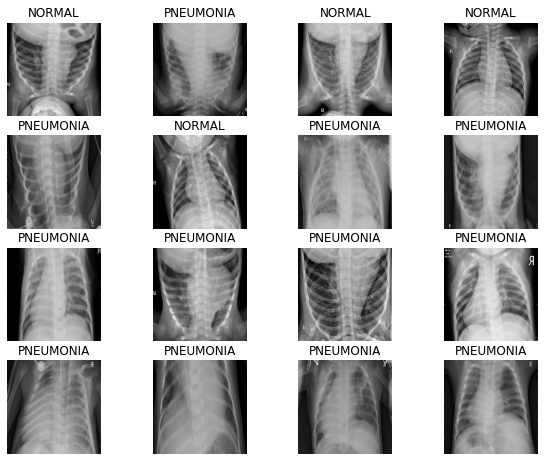

In [27]:
def show_batch(image_batch, label_batch):
    
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)    
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = prepare_for_training(train_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [29]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# patience 5 > val_loss가 최저점에서 5epoch동안 더 안떨어지면 학습 종료
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# val_loss가 가장 낮은 모델 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)






In [31]:
# 모델 훈련  + early stopping을 넣어서 

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es, mc]

    )

Epoch 1/25
261/261 [==============================] - 55s 185ms/step - loss: 0.2401 - accuracy: 0.9071 - precision: 0.9738 - recall: 0.8992 - val_loss: 0.0723 - val_accuracy: 0.9731 - val_precision: 0.9881 - val_recall: 0.9752
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1764 - accuracy: 0.9337 - precision: 0.9793 - recall: 0.9304 - val_loss: 0.1016 - val_accuracy: 0.9596 - val_precision: 0.9932 - val_recall: 0.9516
Epoch 3/25
261/261 [==============================] - 48s 186ms/step - loss: 0.1617 - accuracy: 0.9334 - precision: 0.9833 - recall: 0.9263 - val_loss: 0.0656 - val_accuracy: 0.9798 - val_precision: 0.9973 - val_recall: 0.9752
Epoch 4/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1240 - accuracy: 0.9523 - precision: 0.9876 - recall: 0.9478 - val_loss: 0.1890 - val_accuracy: 0.9404 - val_precision: 0.9444 - val_recall: 0.9765
Epoch 5/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1421 - accura

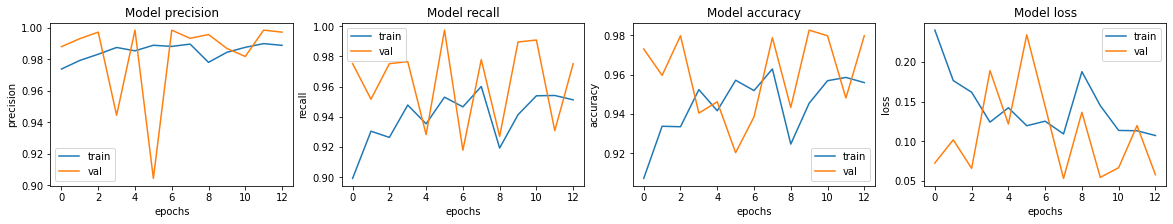

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 1.1055 - accuracy: 0.7901 - precision: 0.7515 - recall: 0.9923
Loss: 1.1054571866989136,
Accuracy: 0.7900640964508057,
Precision: 0.7514563202857971,
Recall: 0.9923076629638672


accuracy가 조금 상승했다. 이제 모델구조를 한번 바꿔보자.
dropout을 모든 layer에서 0.3으로 설정해보자.

In [34]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.3),
        dense_block(128, 0.3),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

배치사이즈도 32로 바꾼후 다시 학습시켜보자.

In [35]:
BATCH_SIZE = 32

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es, mc]

    )

Epoch 1/25
130/130 [==============================] - 35s 215ms/step - loss: 0.0834 - accuracy: 0.9712 - precision: 0.9935 - recall: 0.9682 - val_loss: 0.2454 - val_accuracy: 0.9180 - val_precision: 0.9045 - val_recall: 0.9948
Epoch 2/25
130/130 [==============================] - 28s 215ms/step - loss: 0.1057 - accuracy: 0.9538 - precision: 0.9850 - recall: 0.9514 - val_loss: 0.0790 - val_accuracy: 0.9727 - val_precision: 0.9837 - val_recall: 0.9784
Epoch 3/25
130/130 [==============================] - 28s 214ms/step - loss: 0.0971 - accuracy: 0.9625 - precision: 0.9862 - recall: 0.9633 - val_loss: 0.1476 - val_accuracy: 0.9434 - val_precision: 0.9971 - val_recall: 0.9239
Epoch 4/25
130/130 [==============================] - 28s 218ms/step - loss: 0.0889 - accuracy: 0.9630 - precision: 0.9939 - recall: 0.9558 - val_loss: 0.0738 - val_accuracy: 0.9727 - val_precision: 0.9919 - val_recall: 0.9708
Epoch 5/25
130/130 [==============================] - 29s 221ms/step - loss: 0.1037 - accura

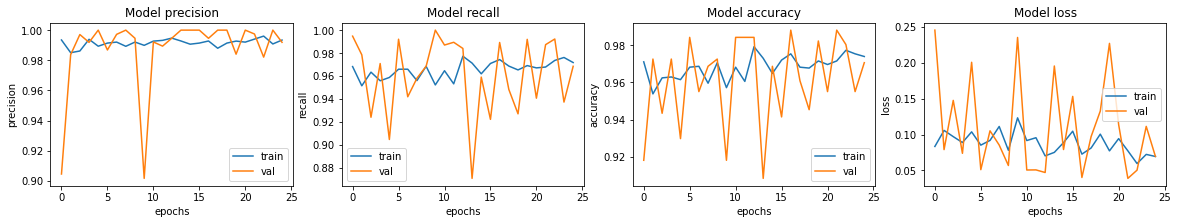

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.4390 - accuracy: 0.7853 - precision: 0.7500 - recall: 0.9846
Loss: 1.4390392303466797,
Accuracy: 0.7852563858032227,
Precision: 0.75,
Recall: 0.9846153855323792


In [39]:
#batch_size를 8로 줄여서 다시 학습시켜보자.
BATCH_SIZE =8

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es, mc]

    )

Epoch 1/25
523/523 [==============================] - 96s 170ms/step - loss: 0.0633 - accuracy: 0.9783 - precision: 0.9936 - recall: 0.9770 - val_loss: 0.0692 - val_accuracy: 0.9750 - val_precision: 0.9960 - val_recall: 0.9699
Epoch 2/25
523/523 [==============================] - 89s 170ms/step - loss: 0.0664 - accuracy: 0.9755 - precision: 0.9938 - recall: 0.9732 - val_loss: 0.0539 - val_accuracy: 0.9827 - val_precision: 0.9947 - val_recall: 0.9817
Epoch 3/25
523/523 [==============================] - 87s 167ms/step - loss: 0.0859 - accuracy: 0.9714 - precision: 0.9926 - recall: 0.9688 - val_loss: 0.2819 - val_accuracy: 0.8875 - val_precision: 0.9985 - val_recall: 0.8487
Epoch 4/25
523/523 [==============================] - 89s 171ms/step - loss: 0.0787 - accuracy: 0.9732 - precision: 0.9924 - recall: 0.9714 - val_loss: 0.0641 - val_accuracy: 0.9798 - val_precision: 0.9934 - val_recall: 0.9791
Epoch 5/25
523/523 [==============================] - 89s 171ms/step - loss: 0.0642 - accura

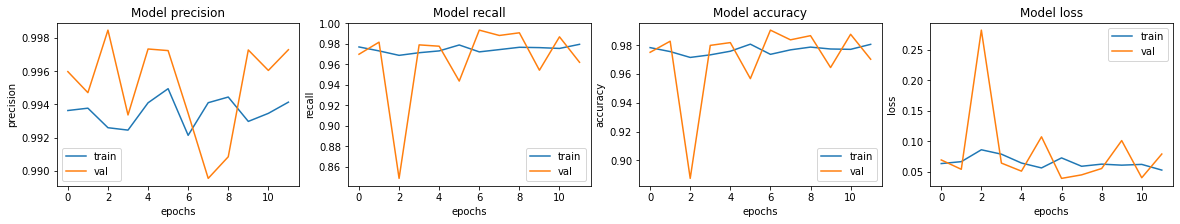

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [42]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 0.7557 - accuracy: 0.8157 - precision: 0.7883 - recall: 0.9641
Loss: 0.7556833028793335,
Accuracy: 0.8157051205635071,
Precision: 0.7882599830627441,
Recall: 0.964102566242218


 배치 사이즈를 줄이니 성능이 향상됨을 확인할 수 있었다. 이번에는 batchnormalization을 빼보고 학습을 해보자.

In [43]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.3),
        dense_block(128, 0.3),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [44]:

BATCH_SIZE =8

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es, mc]

    )

Epoch 1/25
523/523 [==============================] - 96s 171ms/step - loss: 0.0686 - accuracy: 0.9756 - precision: 0.9923 - recall: 0.9748 - val_loss: 0.0476 - val_accuracy: 0.9812 - val_precision: 0.9908 - val_recall: 0.9836
Epoch 2/25
523/523 [==============================] - 90s 171ms/step - loss: 0.0530 - accuracy: 0.9811 - precision: 0.9956 - recall: 0.9790 - val_loss: 0.0616 - val_accuracy: 0.9827 - val_precision: 0.9973 - val_recall: 0.9791
Epoch 3/25
523/523 [==============================] - 88s 169ms/step - loss: 0.0539 - accuracy: 0.9814 - precision: 0.9943 - recall: 0.9806 - val_loss: 0.0821 - val_accuracy: 0.9683 - val_precision: 0.9986 - val_recall: 0.9581
Epoch 4/25
523/523 [==============================] - 89s 171ms/step - loss: 0.0535 - accuracy: 0.9837 - precision: 0.9956 - recall: 0.9825 - val_loss: 0.0369 - val_accuracy: 0.9875 - val_precision: 0.9947 - val_recall: 0.9883
Epoch 5/25
523/523 [==============================] - 90s 173ms/step - loss: 0.0549 - accura

In [45]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.0900 - accuracy: 0.7821 - precision: 0.7480 - recall: 0.9821
Loss: 1.0899829864501953,
Accuracy: 0.7820512652397156,
Precision: 0.748046875,
Recall: 0.9820512533187866


## 회고

1. 어려웠던 점

- 일단 tf.data로 데이터를 batch형태로 나누어서 작업한다는 개념이 어려웠다. 여태까지는 그냥 행렬 자체를 모델에 넣어줬었는데, data인스턴스를 생성해서 전처리를 하고 모델에 넣는다는것이 아직은 조금 어렵게 느껴진다.

- 모델의 하이퍼 파라미터를 결정짓는게 참 어려운것 같다. 어쩔때는 batch size를 줄이면 성능이 좋아지고, 어쩔땐 늘리면 성능이 좋아지기도 한다. 또한 모델의 성능에 영향을 미치는 하이퍼파라미터가 너무 많고, 하이퍼 파라미터 하나를 바꿀때마다 약 30분 가량의 학습시간이 필요하기 때문에 성능을 높이기가 굉장히 어렵다고 생각했다. 

2. 새롭게 시도해본 점

- 데이터 증강 기법에서 좌우반전 뿐만 아니라 상하반전까지 시도해보았다. 이미지의 경우에는 좌우, 상하 반전, 색 반전등의 기법을 바로 떠올릴 수 있는데, 텍스트 데이터에서는 어떤 식으로 처리할 수 있는지 궁금하다.

앞으로 아이펠 노드에 있는 코드를 그대로 복사 붙여넣기 해보기 보다는 필사를 위주로 공부해봐야겠다는 생각이 들었다. 또한, 노드에서 설명이 부족한 부분에 대해서도 내 스스로 더 공부해서 이 파일에 살을 추가하는 식으로 공부해서 하나를 하더라도 제대로 해야겠다고 생각했다.